In [1]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/SchwiftyNotebook_matrix_multiplication")' SchwiftyNotebook_matrix_multiplication

Installing packages:
	.package(path: "/home/ubuntu/workspace/fast-ai-swift/SchwiftyNotebook_matrix_multiplication")
		SchwiftyNotebook_matrix_multiplication
With SwiftPM flags: []
Working in: /tmp/tmpgi9v4elm/swift-install
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no version information available (required by /home/ubuntu/swift/usr/bin/swift)
/home/ubuntu/swift/usr/bin/swift: /home/ubuntu/anaconda3/envs/swift-env/lib/libuuid.so.1: no vers

In [2]:
//export
import Path
import TensorFlow
import SchwiftyNotebook_matrix_multiplication

In [3]:
let thingo = Tensor([-2, -1, 0, 1, 2])

In [4]:
max(0, thingo)

[0.0, 0.0, 0.0, 1.0, 2.0]


In [5]:
thingo.replacing(with: Tensor(zeros: thingo.shape), where: thingo .< 0)

[0.0, 0.0, 0.0, 1.0, 2.0]


In [6]:
time(repeating: 2){ relu(thingo) }

average: 0.176349 ms,   min: 0.16486 ms,   max: 0.187838 ms


In [7]:
//export
public func reLU<T>(tensor: Tensor<T>) -> Tensor<T> where T : FloatingPoint, T: TensorFlowScalar {
    return max(tensor, 0)
}

In [8]:
//export
public func linearCombination<T>(inputs: Tensor<T>, weights: Tensor<T>, bias: Tensor<T>) -> Tensor<T> where T: FloatingPoint, T: TensorFlowScalar {
    return matmul(inputs, weights) + bias
}

# Normalization

In [9]:
let (xTrainingData, yTrainingData, xValidationData, yValidationData) = loadMNISTData(path: mnistPath)

In [10]:
let xTrainingDataNormalized = normalizeTensor(tensor: xTrainingData)
                                        .reshaped(to: [xTrainingData.shape[0], 784])
let xValidationDataNormalized = normalizeTensor(tensor: xValidationData)
                                        .reshaped(to: [xValidationData.shape[0], 784])

In [11]:
// export
public typealias TensorFloat=Tensor<Float>
public func assertNearZero(_ tensor: TensorFloat, _ threshold: Float = 1e-3){
    assert(tensor < threshold, "Expected \(tensor) to be less than \(threshold)")
}

In [12]:
assertNearZero(xTrainingDataNormalized.mean())
assertNearZero(xValidationDataNormalized.mean())
assertNearZero(1 - xTrainingDataNormalized.standardDeviation())
assertNearZero(1 - xValidationDataNormalized.standardDeviation())

In [13]:
let (numberOfImages, numberOfPixels) = (xTrainingDataNormalized.shape[0], xTrainingDataNormalized.shape[1])
let numberOfClasses = 10
let layerOutput = 50
print(numberOfImages, numberOfPixels, numberOfClasses)

60000 784 10


# Initialization

## From Hand

In [14]:
let parameterLayerOne = TensorFloat(randomNormal: [numberOfPixels, layerOutput]) / sqrt(Float(numberOfPixels))
let parameterLayerTwo = TensorFloat(randomNormal: [layerOutput, 1]) / sqrt(Float(layerOutput))

In [15]:
assertNearZero(parameterLayerOne.mean())
assertNearZero(parameterLayerOne.standardDeviation() - 1 / sqrt(Float(numberOfPixels)))

In [16]:
let biasLayerOne = TensorFloat(zeros: [layerOutput])
let biasLayerTwo = TensorFloat(zeros: [1])

In [17]:
assertNearZero(biasLayerOne.mean())
assertNearZero(biasLayerOne.standardDeviation() - 1 / sqrt(Float(numberOfImages)))

In [18]:
print(xValidationDataNormalized.shape, parameterLayerOne.shape, biasLayerOne.shape)

[10000, 784] [784, 50] [50]


### Side Adventure: Timing

In [19]:
//export
import Dispatch

func getTimeUnit(_ nanoSeconds: Double) -> String {
    let powerOfTen = floor(log10(nanoSeconds))
    switch powerOfTen {
        case 1..<3:
            return "\(nanoSeconds) ns"
        case 3..<6:
            return "\(nanoSeconds/1e3) µs"
        case 6..<9: 
            return "\(nanoSeconds/1e6) ms"
        default: 
            return "\(nanoSeconds/1e9) s"
    }
}

// ⏰Time how long it takes to run the specified function, optionally taking
// the average across a number of repetitions.
public func withTime<T>(_ f: () -> T) -> T {
    let start = DispatchTime.now()
    let value = f()
    let end = DispatchTime.now()
    let nanoSeconds = Double(end.uptimeNanoseconds - start.uptimeNanoseconds)
    print("elapsed time: \(getTimeUnit(nanoSeconds))")
    return value
}

In [20]:
withTime{
    print("yeet")
}

yeet
elapsed time: 34.518 µs


In [21]:
let linearWomboCombo = time(repeating: 10) {
    withDevice(.gpu){
        linearCombination(inputs: xValidationDataNormalized, 
                                         weights: parameterLayerOne, 
                                         bias: biasLayerOne)
    }
}

average: 0.0533349 ms,   min: 0.050066 ms,   max: 0.073459 ms


In [22]:
let cpuLinearWomboCombo = time(repeating: 10) {
    withDevice(.cpu){
        linearCombination(inputs: xValidationDataNormalized, 
                                         weights: parameterLayerOne, 
                                         bias: biasLayerOne)
    }
}

average: 25.3595758 ms,   min: 12.700534 ms,   max: 31.077796 ms


In [23]:
let defaultLinearWomboCombo = time(repeating: 10) {
    linearCombination(inputs: xValidationDataNormalized, 
                                     weights: parameterLayerOne, 
                                     bias: biasLayerOne)
}

average: 0.04435490000000001 ms,   min: 0.041731 ms,   max: 0.056036 ms


In [24]:
let thing = withTime { linearCombination(inputs: xValidationDataNormalized, 
                                         weights: parameterLayerOne, 
                                         bias: biasLayerOne) }

elapsed time: 209.535 µs


---

In [25]:
let linearWomboCombo = withTime { linearCombination(inputs: xValidationDataNormalized, 
                                         weights: parameterLayerOne, 
                                         bias: biasLayerOne) }

elapsed time: 174.83 µs


In [26]:
(linearWomboCombo.mean(), linearWomboCombo.standardDeviation())

▿ 2 elements
  - .0 : -0.06561868
  - .1 : 0.96149504


In [27]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


In [28]:
public let plotter = Python.import("matplotlib.pyplot")

In [29]:
linearWomboCombo.shape

▿ [10000, 50]
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 50


In [30]:
let activations = withTime { reLU(tensor: linearWomboCombo) }

elapsed time: 354.005892 ms


In [31]:
print(activations.mean(), activations.standardDeviation()) //relu zeros out all of the stuff below zero (so only ~half remain)

0.34844923 0.5346086


### Kaiming Initialization

In [32]:
let kaimingInitParamOne = TensorFloat(randomNormal: [numberOfPixels, layerOutput]) * (2.0/sqrt(Float(numberOfPixels)))

In [33]:
(kaimingInitParamOne.mean(), kaimingInitParamOne.standardDeviation())

▿ 2 elements
  - .0 : 0.00064951915
  - .1 : 0.07152131


In [34]:
let kaimingWomboCombo = withTime{ linearCombination(inputs: xValidationDataNormalized, 
                                          weights: kaimingInitParamOne, 
                                          bias: biasLayerOne ) }

elapsed time: 203.256 µs


In [35]:
(kaimingWomboCombo.mean(), kaimingWomboCombo.standardDeviation())

▿ 2 elements
  - .0 : -0.10742528
  - .1 : 2.00039


In [36]:
let kaimingActivations = reLU(tensor: kaimingWomboCombo)

In [37]:
(kaimingActivations.mean(), kaimingActivations.standardDeviation())

▿ 2 elements
  - .0 : 0.74013937
  - .1 : 1.1588957


### Basic Model

In [38]:
let kaimingParamOne = TensorFloat(randomNormal: [numberOfPixels, layerOutput]) * (2.0/sqrt(Float(numberOfPixels)))
let kaimingParamTwo = TensorFloat(randomNormal: [layerOutput, 1]) * (2.0/sqrt(Float(layerOutput)))
let biasLayerOne = TensorFloat(zeros: [layerOutput])
let biasLayerTwo = TensorFloat(zeros: [1])

In [39]:
func basicBitch(_ inputTensor: TensorFloat) -> TensorFloat {
    let firstParams = withTime { linearCombination(inputs: inputTensor, 
                                                          weights: kaimingParamOne, 
                                                          bias: biasLayerOne) }
    let firstActivations = withTime { reLU(tensor: firstParams)}
    return withTime{ linearCombination(inputs: firstActivations, 
                             weights: kaimingParamTwo, 
                             bias: biasLayerTwo) }
}

In [40]:
let prediction = basicBitch(xValidationDataNormalized)

elapsed time: 181.359 µs
elapsed time: 353.554372 ms
elapsed time: 135.511 µs


🤔 Why is reLU so sloooow???

Turns out its just slow the first time...

In [41]:
for i in 1...10 {
 withTime { relu(kaimingWomboCombo)}   
}

elapsed time: 353.918928 ms
elapsed time: 179.576 µs
elapsed time: 133.164 µs
elapsed time: 121.189 µs
elapsed time: 120.1 µs
elapsed time: 121.394 µs
elapsed time: 117.264 µs
elapsed time: 118.779 µs
elapsed time: 118.9 µs
elapsed time: 120.086 µs


### Calculating Loss

In [42]:
(prediction.shape, yValidationData.shape)

▿ 2 elements
  ▿ .0 : [10000, 1]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 1
  ▿ .1 : [10000]
    ▿ dimensions : 1 element
      - 0 : 10000


In [43]:
prediction.squeezingShape(at: -1).shape

▿ [10000]
  ▿ dimensions : 1 element
    - 0 : 10000


In [44]:
(prediction.squeezingShape(at: -1) - TensorFloat(yValidationData)).squared().mean()

113.33705


In [45]:
func _meanSquaredError(_ y: TensorFloat, _ yHat: TensorFloat) -> TensorFloat {
    return (y - yHat.squeezingShape(at: [1])).squared().mean()
}

In [46]:
let trainingPredictions = basicBitch(xTrainingDataNormalized)

elapsed time: 201.489 µs
elapsed time: 353.772111 ms
elapsed time: 121.437 µs


In [47]:
(yTrainingData.shape, trainingPredictions.squeezingShape(at: [1]).shape)

▿ 2 elements
  ▿ .0 : [60000]
    ▿ dimensions : 1 element
      - 0 : 60000
  ▿ .1 : [60000]
    ▿ dimensions : 1 element
      - 0 : 60000


In [48]:
print(_meanSquaredError(TensorFloat(yValidationData), prediction))
_meanSquaredError(TensorFloat(yTrainingData), trainingPredictions)

113.33705


113.677086


# Auto Diff

In [49]:
for x in stride(from: 0.0, 
                through: 1, by: 0.1){
    print(cos(x), sin(x))
}

1.0 0.0
0.9950041652780258 0.09983341664682815
0.9800665778412416 0.19866933079506122
0.955336489125606 0.2955202066613396
0.9210609940028851 0.3894183423086505
0.8775825618903728 0.479425538604203
0.8253356149096782 0.5646424733950355
0.7648421872844884 0.6442176872376911
0.6967067093471654 0.7173560908995228
0.6216099682706644 0.7833269096274834
0.5403023058681398 0.8414709848078965


**Note:** `in` is the arrow if the closure

In [50]:
let mathyBoiGradientFunction = gradient { (x: Double) in x * 9 }

In [51]:
mathyBoiGradientFunction(69)

9.0


The derivative of $9x$ with respect to $x$ is just 9

In [52]:
let sineGraident = gradient { (x: Double) in sin(x)}
let cosineGraident = gradient { (x: Double) in cos(x)}

for x in stride(from: 0.0, 
                through: 1, by: 0.1){
    print(cosineGraident(x), sineGraident(x))
}

-0.0 1.0
-0.09983341664682815 0.9950041652780258
-0.19866933079506122 0.9800665778412416
-0.2955202066613396 0.955336489125606
-0.3894183423086505 0.9210609940028851
-0.479425538604203 0.8775825618903728
-0.5646424733950355 0.8253356149096782
-0.6442176872376911 0.7648421872844884
-0.7173560908995228 0.6967067093471654
-0.7833269096274834 0.6216099682706644
-0.8414709848078965 0.5403023058681398


The derivative of sin is cosine and the derivitive of cosine is -sine. 2cool4Me

### Basics Of Mean Squared Error

In [53]:
func tracer(functionName: String = #function) { //I'm already tracer
    print(functionName)
}

In [54]:
let closureDude = {
    tracer()
}

closureDude()

__lldb_expr_425


In [55]:
func imAlreadyTracer() {
    tracer()
    print("maybe I'll be tracer")
}

imAlreadyTracer()

imAlreadyTracer()
maybe I'll be tracer


In [56]:
let a = TensorFloat([[1, 2, 3],[4,5,6]])
a.shape

▿ [2, 3]
  ▿ dimensions : 2 elements
    - 0 : 2
    - 1 : 3


In [57]:
a.sum(squeezingAxes: [0, 1])

21.0


In [58]:
func squareTensor(_ x: TensorFloat) -> TensorFloat {
    tracer()
    return x * x
}

func 𝛁squareTensor(_ x: TensorFloat) -> TensorFloat {
    tracer()
    return 2 * x
}

func meanOfTensor(_ x: TensorFloat) -> TensorFloat {
    tracer()
    return x.sum(squeezingAxes: [0, 1]) / Float(x.shape[0])
}

// The derivative of the mean with respect to x is just 1/n because the mean is just sum(weights)/n
// cus the deriviative of x/2 with respect to x is just 1/2
func 𝛁meanOfTensor(_ x: TensorFloat) -> TensorFloat {
    tracer()
    return TensorFloat(ones: [1]) / Float(x.shape[0])
}


In [59]:
(prediction.mean(), meanOfTensor(prediction))

meanOfTensor(_:)


▿ 2 elements
  - .0 : -5.4451227
  - .1 : -5.4451227


In [60]:
//export
public func assertEquals(_ a: TensorFloat, _ b: TensorFloat) {
    // Check shapes match so broadcasting doesn't hide shape errors.
    assert(a.shape == b.shape)
    assertNearZero(a-b)
}

In [61]:
func meanSquareError(_ x: TensorFloat) -> TensorFloat {
    return meanOfTensor(squareTensor(x))
}

func 𝛁meanSquareError(_ x: TensorFloat) -> TensorFloat {
    return 𝛁meanOfTensor(squareTensor(x)) * 𝛁squareTensor(x)
}

let myGradientSquareError = 𝛁meanSquareError(prediction)
let fancyPantsLibraryGradient = gradient { (x: TensorFloat) in x.squared().mean()}(prediction
                                                                                  )

assertEquals(fancyPantsLibraryGradient, myGradientSquareError)

squareTensor(_:)
𝛁meanOfTensor(_:)
𝛁squareTensor(_:)


In [62]:
func square𝛁_Chain(x: TensorFloat, ddx: TensorFloat) -> TensorFloat {
    tracer()
    return 2 * x * ddx
}

func mean𝛁_Chain(x: TensorFloat, ddx: TensorFloat) -> TensorFloat {
    tracer()
    return (TensorFloat(ones: [1]) / Float(x.shape[0])) * ddx
}

In [63]:
func squareWomboCombo(_ x: TensorFloat) -> (value: TensorFloat, chain: (TensorFloat) -> TensorFloat){
    tracer()
    return (value: x * x, chain: { ddx in square𝛁_Chain(x: x, ddx: ddx) })
}

func meanWomboCombo(_ x: TensorFloat) -> (value: TensorFloat, chain: (TensorFloat) -> TensorFloat){
    tracer() // x is already squared at this point, no need to calculate things done to it.
    return (value: x.sum(squeezingAxes: [0, 1]) / Float(x.shape[0]), 
            chain: { ddx in mean𝛁_Chain(x: x, ddx: ddx )})
}

In [64]:
func meanSquaredErrorWithGradinent(_ x: TensorFloat) -> (value: TensorFloat, chain: (TensorFloat) -> TensorFloat) {
    tracer()
    let (squared, squaredChain) = squareWomboCombo(x)
    let (mean, meanChain) = meanWomboCombo(squared)
    
    return (value: mean, chain: { first in squaredChain(meanChain(first)) })
}

In [65]:
let (meanSquaredErr, mseGradient) = meanSquaredErrorWithGradinent(prediction)

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)


In [66]:
assertEquals(prediction.squared().mean(), meanSquaredErr)

In [67]:
assertEquals(fancyPantsLibraryGradient, mseGradient(TensorFloat(ones: [1]))) // start of chain's ddx is just 1

mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)


\o/

In [68]:
func reLUAndGradient(_ inputTensor: TensorFloat) -> (value: TensorFloat,
                                                    chain: (TensorFloat) -> TensorFloat) {
    tracer()
    return (value: max(0.0, inputTensor), 
            chain: { 
                ddxWomboCombo in max(0.0, ddxWomboCombo) })
}

womboCombo = inputs * parameters + bias

_Partial Derivatives below_

```python

dWC/dparameters = inputs # params

dWC/dinput = parameters # input

dWC/dbias = 1 # bias

```


meanSquaredError(womboCombo(reLU(womboCombo())))

'meanSquaredError(womboCombo(reLU(womboCombo()))) * 'womboCombo(reLU(womboCombo())) * 'reLU(womboCombo()) * 'womboCombo()

In [69]:
(input: matmul(xValidationDataNormalized, kaimingInitParamOne).shape, 
 parameters: kaimingParamTwo.shape,
 bias: biasLayerTwo.shape,
 ddx: myGradientSquareError.shape)

▿ 4 elements
  ▿ input : [10000, 50]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 50
  ▿ parameters : [50, 1]
    ▿ dimensions : 2 elements
      - 0 : 50
      - 1 : 1
  ▿ bias : [1]
    ▿ dimensions : 1 element
      - 0 : 1
  ▿ ddx : [10000, 1]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 1


In [70]:
let firstCombo = linearCombination(inputs: xValidationDataNormalized, weights: kaimingParamOne, bias: biasLayerOne)
let activations = reLU(tensor: firstCombo)
let lastCombo = linearCombination(inputs: activations, weights: kaimingParamTwo, bias: biasLayerTwo) 

(lastCombo.shape, yValidationData.shape)

▿ 2 elements
  ▿ .0 : [10000, 1]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 1
  ▿ .1 : [10000]
    ▿ dimensions : 1 element
      - 0 : 10000


In [71]:
yValidationData.expandingShape(at: 1).shape

▿ [10000, 1]
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 1


In [72]:
let error = lastCombo - TensorFloat(yValidationData).expandingShape(at: 1)
error.shape

▿ [10000, 1]
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 1


In [73]:
let (loss, mseGradientChain) = meanSquaredErrorWithGradinent(error)

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)


In [74]:
let ddxMSE = mseGradientChain(TensorFloat(1)) // start of the ddx chain is just 1
ddxMSE.shape

mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)


▿ [10000, 1]
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 1


In [75]:
(inputs: activations.shape, ddx: ddxMSE.shape)

▿ 2 elements
  ▿ inputs : [10000, 50]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 50
  ▿ ddx : [10000, 1]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 1


In [76]:
// the partial derivative of wombo combo with repect to the parameters is just the activations (or inputs)
let _ddxParameters = withTime { matmul(activations.transposed(), ddxMSE) }
let ddxParameters = withTime { matmul(activations.transposed(), ddxMSE) }
ddxParameters.shape

elapsed time: 354.141575 ms
elapsed time: 543.798 µs


▿ [50, 1]
  ▿ dimensions : 2 elements
    - 0 : 50
    - 1 : 1


**Squirrel**: Looks like the notbook hase some spinup time, after that it becomes heckin fast.

In [77]:
(parameters: kaimingParamTwo.shape, ddx: ddxMSE.shape)

▿ 2 elements
  ▿ parameters : [50, 1]
    ▿ dimensions : 2 elements
      - 0 : 50
      - 1 : 1
  ▿ ddx : [10000, 1]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 1


In [78]:
let ddxActivations = matmul(ddxMSE, kaimingParamTwo.transposed()) // the partial derivative of wombo combo with respects to activations is the parameters.
ddxActivations.shape

▿ [10000, 50]
  ▿ dimensions : 2 elements
    - 0 : 10000
    - 1 : 50


In [79]:
let activationsGradient = ddxActivations.sum(squeezingAxes: [0])
activationsGradient.shape

▿ [50]
  ▿ dimensions : 1 element
    - 0 : 50


In [80]:
// These two should match :D (this is the gradient learny bit)
assert(activationsGradient.expandingShape(at: 1).shape == kaimingParamTwo.shape)

In [81]:
(bias: biasLayerTwo.shape, ddx: ddxMSE.shape)

▿ 2 elements
  ▿ bias : [1]
    ▿ dimensions : 1 element
      - 0 : 1
  ▿ ddx : [10000, 1]
    ▿ dimensions : 2 elements
      - 0 : 10000
      - 1 : 1


In [82]:
let ddxBias = ddxMSE.unbroadcasted(to: biasLayerTwo.shape) // reduces and sums the tensor apparently :|
ddxBias.shape

▿ [1]
  ▿ dimensions : 1 element
    - 0 : 1


//Fundi to derive

womboCombo = inputs * parameters + bias

_Partial Derivatives below_

```python

dWC/di = parameters # input

dWC/dp = inputs # params

dWC/db = 1 # bias

```

In [83]:
func womboComboPlusGradient(input: TensorFloat, 
                          parameter: TensorFloat,
                          bias: TensorFloat) -> (value: TensorFloat,
                                                 // Three Parameters in 3 Partial Derivatives out :D
                                                 chain: (TensorFloat) -> (TensorFloat, TensorFloat, TensorFloat)) {
    return (value: linearCombination(inputs: input, 
                                     weights: parameter, 
                                     bias: bias),
           chain: { (ddx: TensorFloat) in (
                           matmul(ddx, parameter.transposed()),
                           matmul(input.transposed(), ddx),
                            ddx.unbroadcasted(to: bias.shape)) })
}

In [84]:
let (lastCombination, lastCombinationGradientChain) = womboComboPlusGradient(input: activations, 
                                                                            parameter: kaimingParamTwo, 
                                                                            bias: biasLayerTwo)

In [85]:
assertEquals(lastCombo, lastCombination)

In [86]:
let (inputPartial, parameterPartial, biasPartial) = lastCombinationGradientChain(ddxMSE)

In [87]:
assertEquals(inputPartial, ddxActivations)
assertEquals(parameterPartial, ddxParameters)
assertEquals(biasPartial, ddxBias)

In [88]:
// Model
let (parameterOutputOne, wcGradientChainOne) = womboComboPlusGradient(input: xValidationDataNormalized, 
                                                                     parameter: kaimingParamOne, 
                                                                     bias: biasLayerOne)
let (firstLayerActivations, reLUGradientChain) = reLUAndGradient(parameterOutputOne)
let (predictions, wcGradientChainTwo) = womboComboPlusGradient(input: firstLayerActivations, 
                                                                     parameter: kaimingParamTwo, 
                                                                     bias: biasLayerTwo)

let error =  TensorFloat(yValidationData).expandingShape(at: 1) - predictions

let (loss, gradientLossChain) = meanSquaredErrorWithGradinent(error)
        
let (ddxMSE) = gradientLossChain(TensorFloat(1))

let (ddxActivations,ddxKaimingParamTwo, ddxBiasLayerTwo) = wcGradientChainTwo(ddxMSE)

let (ddxfirstActivations) = reLUGradientChain(ddxActivations)

let (ddxInput, ddxKaimingParamOne, ddxBiasLayerOne) = wcGradientChainOne(ddxfirstActivations)

reLUAndGradient(_:)
meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)


In [104]:
func layerCombinationWithGradient(input: TensorFloat,
                                  weightParameter: TensorFloat,
                                  biasParameter: TensorFloat) -> (value: TensorFloat,
                                                                  chain: (TensorFloat) -> (TensorFloat, TensorFloat, TensorFloat)) {
    // shape (tensorName)
    // m x n (input) * n x o (weightParameter) = m x o (ddx)
    return (value: matmul(input, weightParameter) + biasParameter,
            chain: { (ddx: TensorFloat) in (
                //Derivative with respect to input = ddx * weightParameter
                matmul(ddx, weightParameter.transposed()),
                //Derivative with respect to weightParameter = ddx * input
                matmul(input.transposed(), ddx),
                //Derivative with respect to biasParameter = ddx * 1 (shape of bias parameter)
                ddx.unbroadcasted(to: biasParameter.shape)
            )})
}

In [105]:
var a = TensorFloat([1, 2, 3])
let b = TensorFloat([3, 2, 1])

a -= b
a

[-2.0,  0.0,  2.0]


In [254]:
struct HyperParameters {
    let learningRate: Float
    
    init(learningRate: Float){
        self.learningRate = learningRate
    }
}


class SimpleLayer {
    private var gradientChain: (TensorFloat) -> (output: TensorFloat,
                                                  weightGradient: TensorFloat,
                                                  biasGradient: TensorFloat)
    var weightParameter: TensorFloat
    var biasParameter: TensorFloat
    
    init(inputSize: Int, outputSize: Int) {
        self.weightParameter = TensorFloat(randomNormal: [inputSize, outputSize]) * (2/sqrt(Float(inputSize)))
        self.biasParameter = TensorFloat(zeros: [outputSize])
        self.gradientChain = { (input: TensorFloat) in (output: TensorFloat(zeros: [0]), 
                                weightGradient: TensorFloat(zeros: [0]),
                                biasGradient: TensorFloat(zeros: [0])) }
    }
    
    func forward(inputTensor: TensorFloat) -> TensorFloat {
        let (womboComboValue, womboComboChain) = layerCombinationWithGradient(input: inputTensor, 
                                                                              weightParameter: self.weightParameter, 
                                                                              biasParameter: self.biasParameter)
//         let (activations, activationChain) = reLUAndGradient(womboComboValue)
        self.gradientChain = {(ddx: TensorFloat) in
//                                  let ddxActivations = activationChain(ddx)
                                 let (ddxInput, ddxWeightParameter, ddxBiasParameter) = 
                                      womboComboChain(ddx)
                                 //ddxInput = m x o * o x n = m * n
                                 return (output: ddxInput, 
                                         weightGradient: ddxInput,
                                         biasGradient: ddxBiasParameter)
                             }
        return womboComboValue
    }
    
    func backward(ddx: TensorFloat, hyperParameters: HyperParameters) -> TensorFloat {
        let (ddxOutput, weightGradient, biasGradient) = self.gradientChain(ddx)
        print("param/input", ddxOutput.shape, weightGradient.shape)
        let squishyBoi = weightGradient.sum(squeezingAxes: [0])
        self.weightParameter = self.weightParameter - (hyperParameters.learningRate * squishyBoi.expandingShape(at: 1))
        self.biasParameter -= hyperParameters.learningRate * biasGradient
        return ddxOutput
    }
    
}

In [255]:
let a = TensorFloat([[1, 2, 3], [3,2,1]])
let b = TensorFloat([3, 2, 1])
a - b

[[-2.0,  0.0,  2.0],
 [ 0.0,  0.0,  0.0]]


In [256]:
let n = 100
let inputPoints2 = TensorFloat(randomNormal: [100, 1])
inputPoints2[1]

[-0.0003375158]


In [257]:
let A = inputPoints2.concatenated(with: TensorFloat(ones: [100, 1]), alongAxis: 1)
A[1]

[-0.0003375158,           1.0]


In [258]:
let x = TensorFloat([2, 7])
x.expandingShape(at: 1).shape

▿ [2, 1]
  ▿ dimensions : 2 elements
    - 0 : 2
    - 1 : 1


In [259]:
let y = matmul(A, x.expandingShape(at: 1)) + (TensorFloat(randomNormal: [100, 1], seed: (69, 420)) * 2)
y.shape

▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


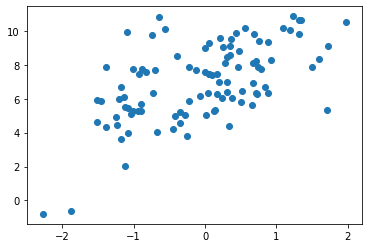

None


In [260]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: y.makeNumpyArray())
plotter.show()

In [261]:
let simpleLayer = SimpleLayer(inputSize: 2, outputSize: 1)


In [262]:
let yHat = simpleLayer.forward(inputTensor: A)

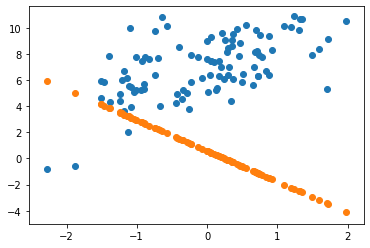

None


In [263]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: y.makeNumpyArray())
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
plotter.show()

In [264]:
let (mse, mseChain) = meanSquaredErrorWithGradinent(y - yHat)
mse

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)


54.57464


In [265]:
let hyperParams = HyperParameters(learningRate: 5e-2)

In [266]:
let ddxMSE = mseChain(TensorFloat(ones: [1]))
ddxMSE.shape

mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)


▿ [100, 1]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 1


In [267]:
let (ddxLayerOne) = simpleLayer.backward(ddx: ddxMSE, hyperParameters: hyperParams)

param/input [100, 2] [100, 2]


In [268]:
ddxLayerOne.shape

▿ [100, 2]
  ▿ dimensions : 2 elements
    - 0 : 100
    - 1 : 2


In [269]:
let yHat = simpleLayer.forward(inputTensor: A)

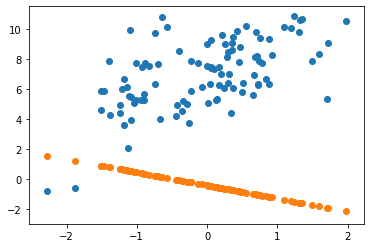

None


In [270]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: y.makeNumpyArray())
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: yHat.makeNumpyArray())
plotter.show()

In [271]:
let (mse, mseChain) = meanSquaredErrorWithGradinent(y - yHat)
mse

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)


61.845303


In [272]:
let layerToTrain = SimpleLayer(inputSize: 2, outputSize: 1)

In [273]:
let trainingHyperParameters = HyperParameters(learningRate: 1e-2)

In [274]:
let initialYHat = layerToTrain.forward(inputTensor: A)

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)


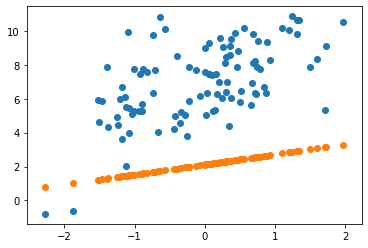

27.992369


In [275]:
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: y.makeNumpyArray())
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: initialYHat.makeNumpyArray())
plotter.show()
let (mse, mseChain) = meanSquaredErrorWithGradinent(y - initialYHat)
mse

In [276]:
time(repeating: 10) {
    let yHat = layerToTrain.forward(inputTensor: A)
    let (loss, lossChain) = meanSquaredErrorWithGradinent(y - yHat)
    print("Loss: \(loss)")
    layerToTrain.backward(ddx: lossChain(TensorFloat([1])), 
                                         hyperParameters: trainingHyperParameters)
}

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
Loss: 27.992369
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)
param/input [100, 2] [100, 2]
meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
Loss: 31.135103
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)
param/input [100, 2] [100, 2]
meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
Loss: 34.433544
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)
param/input [100, 2] [100, 2]
meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
Loss: 37.862293
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)
param/input [100, 2] [100, 2]
meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
Loss: 41.395668
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)
param/input [100, 2] [100, 2]
meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)
Loss: 45.009228
mean𝛁_Chain(x:ddx:)
square𝛁_Chain(x:ddx:)
param/input [100, 2] [100, 2]
meanSquaredErrorWithGradinen

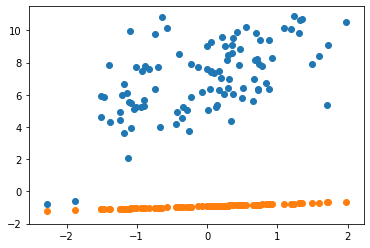

meanSquaredErrorWithGradinent(_:)
squareWomboCombo(_:)
meanWomboCombo(_:)


67.41159


In [277]:
let finalYHat = layerToTrain.forward(inputTensor: A)
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: y.makeNumpyArray())
plotter.scatter(x: A.slice(lowerBounds: [0, 0], upperBounds:[A.shape[0], 1] ).makeNumpyArray(), 
                y: finalYHat.makeNumpyArray())
plotter.show()
let (mse, mseChain) = meanSquaredErrorWithGradinent(y - finalYHat)
mse